<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/AE_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Auto-Encoder


In [22]:
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision
import torch.utils as utils

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [23]:
# Read CIFAR-10 data and convert each image to grayscale for input
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, path, transform1 = None, transform2 = None, train = True):
        self.transform1 = torchvision.transforms.ToTensor()
        self.transform2 = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor()])
        self.train = train

        self.labelset = torchvision.datasets.CIFAR10(root = path, train = self.train, download = True)
        self.dataset = torchvision.datasets.CIFAR10(root = path, train = self.train, download = True)

        self.datanum = len(self.dataset)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_label = self.labelset[idx][0]
        out_data = self.dataset[idx][0]

        if self.transform1:
            out_label = self.transform1(out_label)

        if self.transform2:
            out_data = self.transform1(out_data)

        return out_data, out_label

In [24]:
# Load Data
dataset = Mydatasets('./data', train=True)
print(dataset[0][0].shape)
print(dataset[0][1].shape)

batch_size = 16

dataloader_train = utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)


Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


In [25]:
import torch.nn as nn


# make tensor.view() Module to use it in Sequential
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self,x):
        return x.view(self.shape)

In [26]:
# Network

class CNV_AE(nn.Module):
  def __init__(self):
    super(CNV_AE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
#        nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
#        nn.Tanh(),
    )
    self.lin1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(8*8*32, 512),
#        nn.Softmax(dim=1),
    )
    self.softmax = nn.Sequential(
        nn.Softmax(dim=1),
    )
    self.lin2 = nn.Sequential(
        nn.Linear(512, 8*8*32),
        Reshape(-1, 32, 8, 8),
    )
    self.decorder = nn.Sequential(
#        nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#        nn.Tanh(),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid(),
    )
  def forward(self, x1):
    x2 = self.encoder(x1)
    z1 = self.lin1(x2)
    z = self.softmax(z1)
    z2 = self.lin2(z)
    y  = self.decorder(z2)
    return y, z

In [27]:
# Define model
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNV_AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

print(model)

CNV_AE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (lin1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=512, bias=True)
  )
  (softmax): Sequential(
    (0): Softmax(dim=1)
  )
  (lin2): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): Reshape()
  )
  (decorder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)


In [28]:
# Training
nepoch = 100

for i in range(nepoch):
  print(f"EPOCH: {i+1}")

  ### Train ###
  model.train()
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    model.zero_grad()
    y, z = model(x)
    loss = criterion(y, t)
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    y, z = model(x)
    loss = criterion(y, t)
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")


EPOCH: 1
  train loss: 0.034478662129640576
EPOCH: 2
  train loss: 0.028688151884675026
EPOCH: 3
  train loss: 0.02625514292895794
EPOCH: 4
  train loss: 0.02503913300305605
EPOCH: 5
  train loss: 0.023655635638237
EPOCH: 6
  train loss: 0.022844058525562285
EPOCH: 7
  train loss: 0.021231704573333263
EPOCH: 8
  train loss: 0.019513537148833277
EPOCH: 9
  train loss: 0.01852978028893471
EPOCH: 10
  train loss: 0.01779439446747303
EPOCH: 11
  train loss: 0.017252049655616282
EPOCH: 12
  train loss: 0.016396809396147728
EPOCH: 13
  train loss: 0.015868662133812904
EPOCH: 14
  train loss: 0.015428967077732086
EPOCH: 15
  train loss: 0.015024707231521606
EPOCH: 16
  train loss: 0.01467812533557415
EPOCH: 17
  train loss: 0.01439846545189619
EPOCH: 18
  train loss: 0.014132066286802292
EPOCH: 19
  train loss: 0.0139616279104352
EPOCH: 20
  train loss: 0.013760708231925965
EPOCH: 21
  train loss: 0.013586938543617725
EPOCH: 22
  train loss: 0.013420764803886414
EPOCH: 23
  train loss: 0.0132

torch.Size([16, 3, 32, 32])
[[5.7881582e-03 1.5898154e-07 1.0449715e-02 ... 1.7613115e-07
  1.5106298e-07 1.7803966e-07]
 [7.5136092e-03 1.6153173e-06 1.1928491e-02 ... 1.2702286e-06
  1.1241610e-06 1.4149641e-06]
 [7.9279412e-03 8.9196112e-07 1.1459415e-02 ... 7.2964752e-07
  6.2807896e-07 7.8764930e-07]
 ...
 [6.8077943e-03 4.7593622e-07 1.0376601e-02 ... 4.1176241e-07
  3.5831184e-07 3.8009338e-07]
 [6.0511157e-03 9.2872409e-07 1.1280440e-02 ... 7.7159910e-07
  6.7364988e-07 8.0385723e-07]
 [6.1840601e-03 1.1135060e-06 1.1115966e-02 ... 1.0723003e-06
  9.1384135e-07 1.0566721e-06]]
(32, 32, 3)


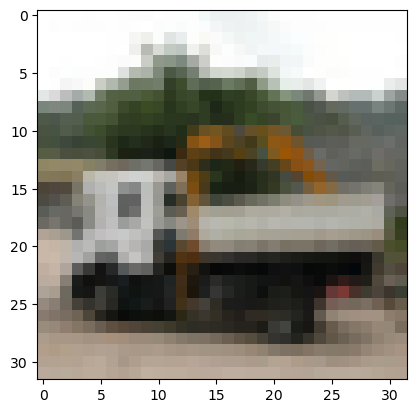

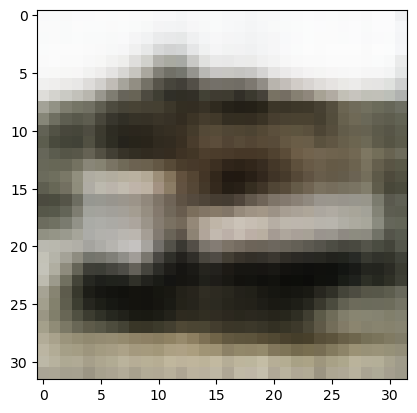


(32, 32, 3)


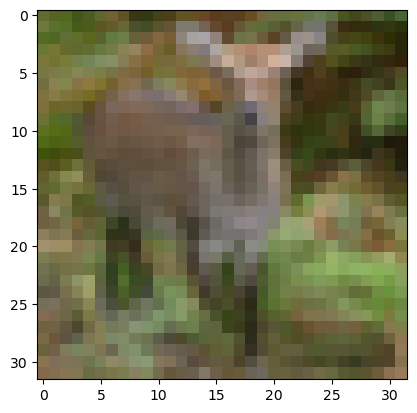

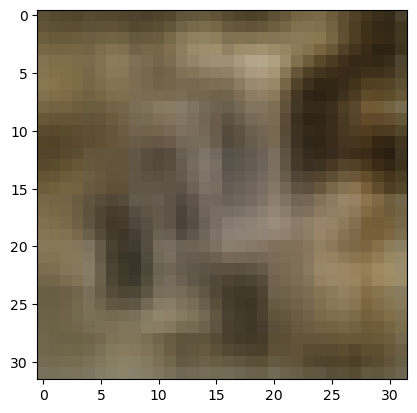


(32, 32, 3)


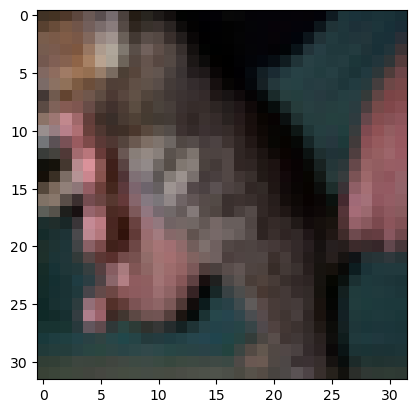

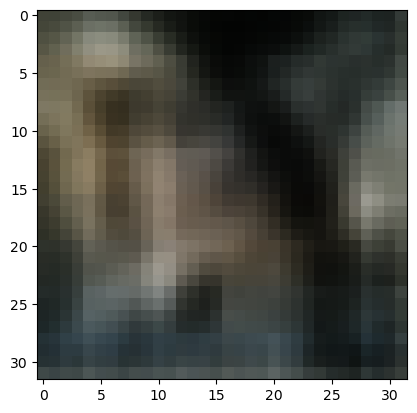


(32, 32, 3)


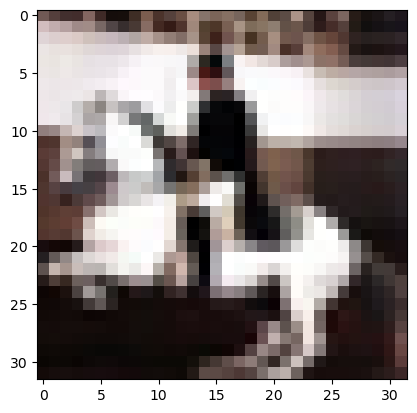

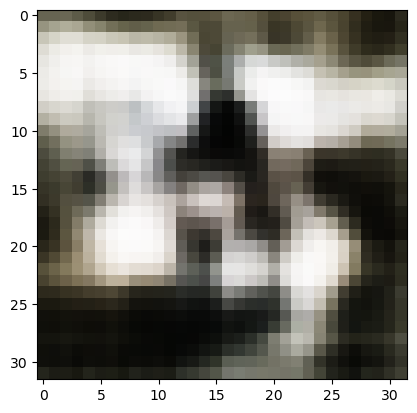


(32, 32, 3)


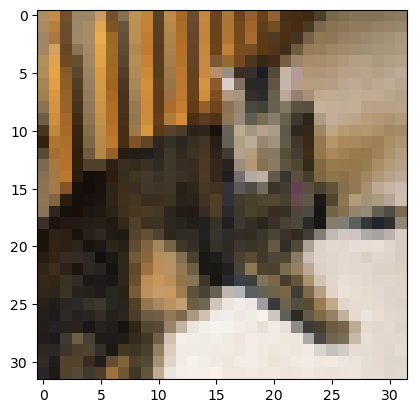

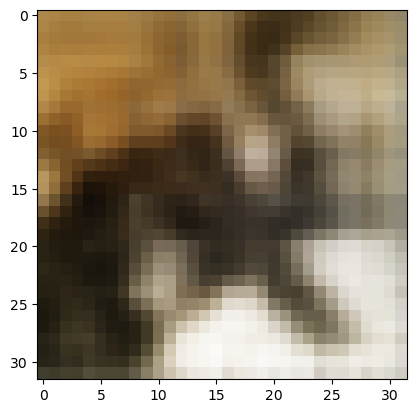


(32, 32, 3)


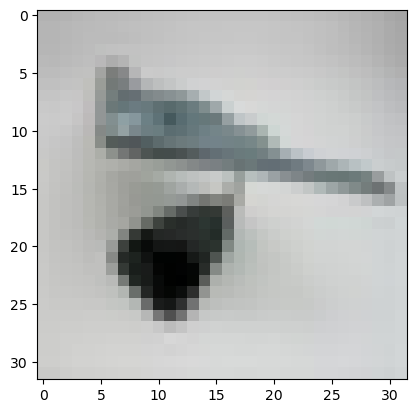

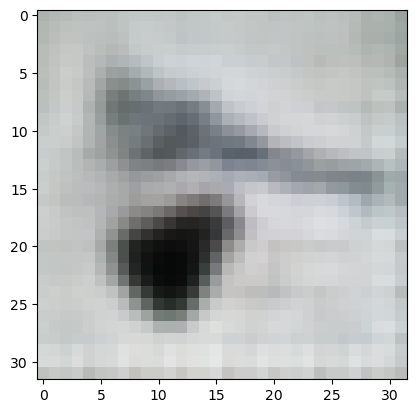


(32, 32, 3)


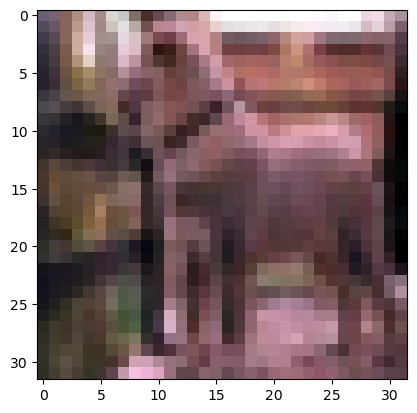

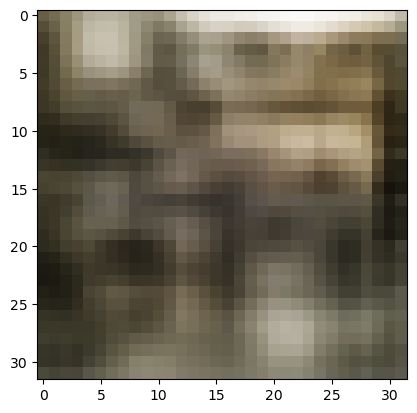


(32, 32, 3)


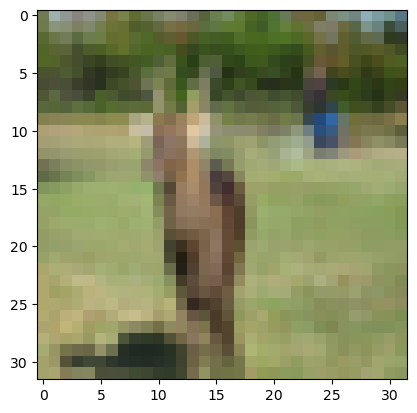

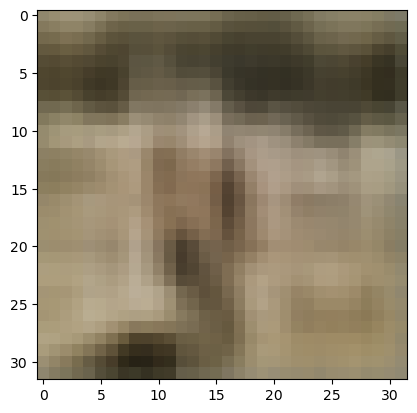


(32, 32, 3)


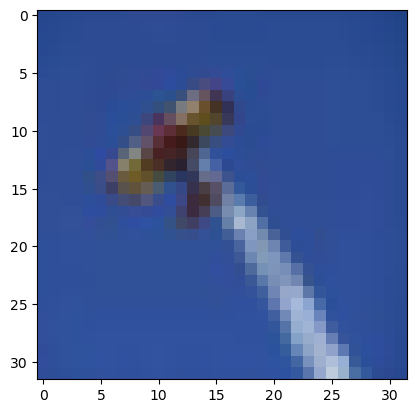

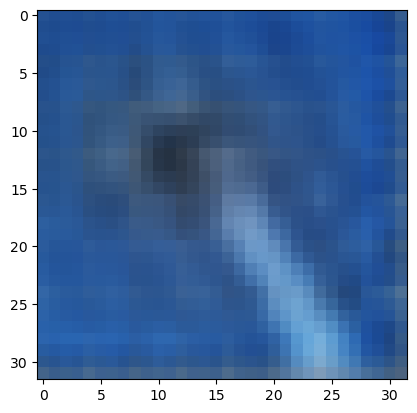


(32, 32, 3)


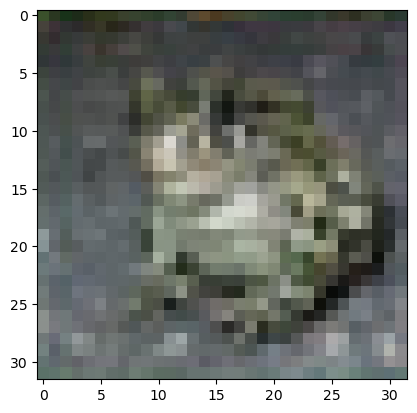

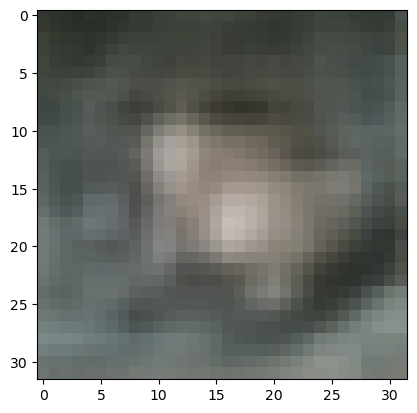


(32, 32, 3)


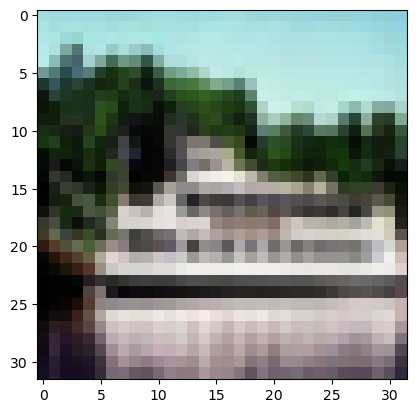

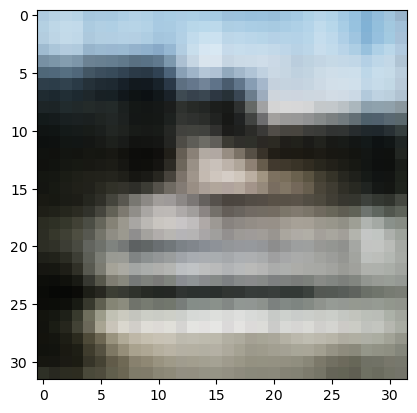


(32, 32, 3)


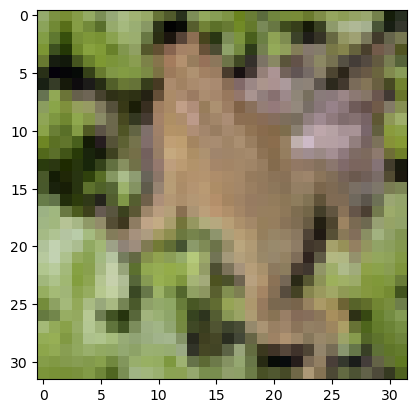

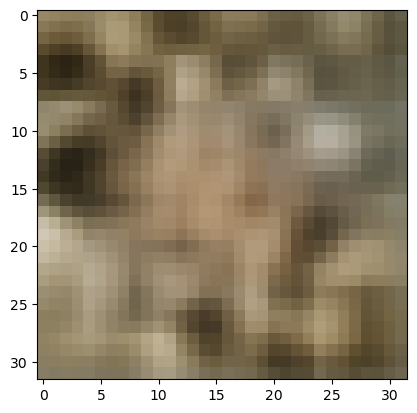


(32, 32, 3)


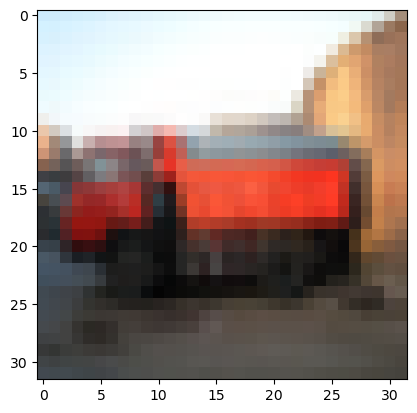

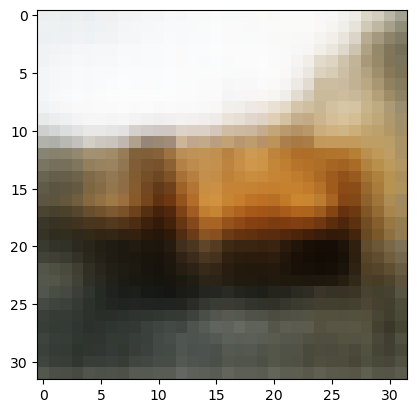


(32, 32, 3)


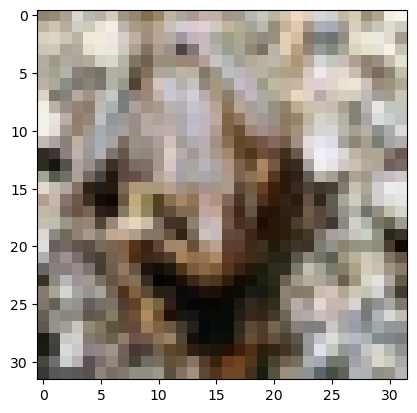

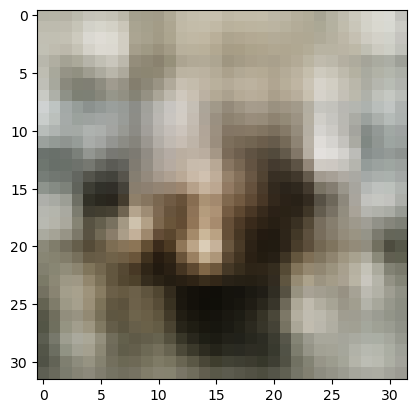


(32, 32, 3)


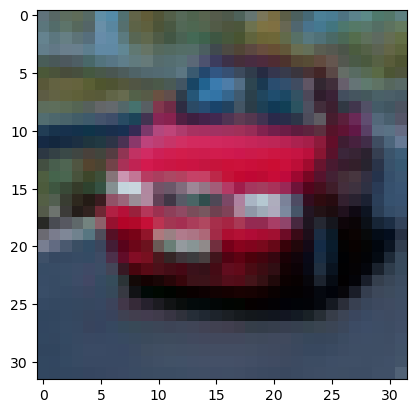

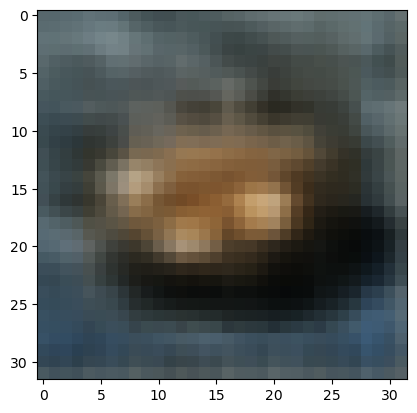


(32, 32, 3)


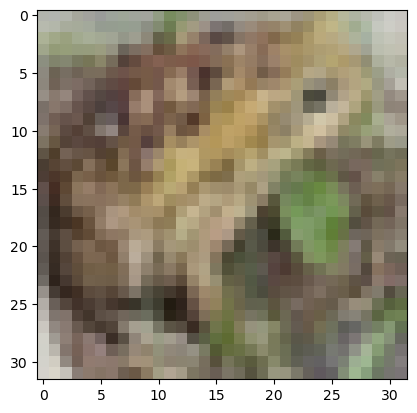

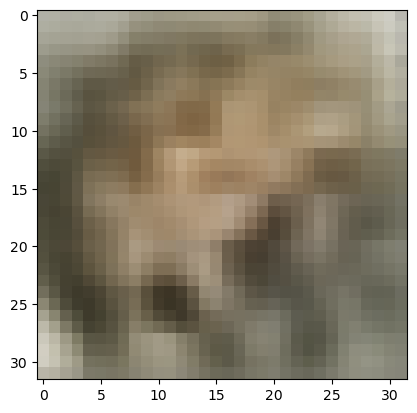

In [36]:
# Visualization

import matplotlib.pyplot as plt
%matplotlib inline

model.eval()
for x, t in dataloader_train:
    print(x.shape)
    x = x.to(device)
    y, z = model(x)
    z = z.cpu().detach().numpy()
    print(z)
    for i in range(len(t)):
        yimg = y[i].cpu().permute(1,2,0).detach().numpy()
        print(yimg.shape)
        timg = t[i].permute(1,2,0).detach().numpy()
        plt.imshow(timg)
        plt.show()
        plt.imshow(yimg)
        plt.show()
        print("\n =================== ")

    break

(16, 512)
[270 199 210 104 219 199 268 199 199 199 268 199 270 199 210 199]


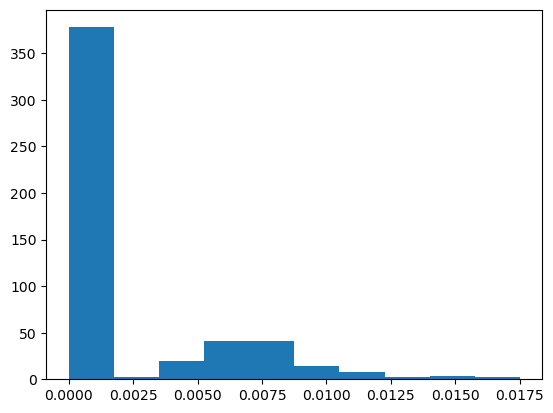

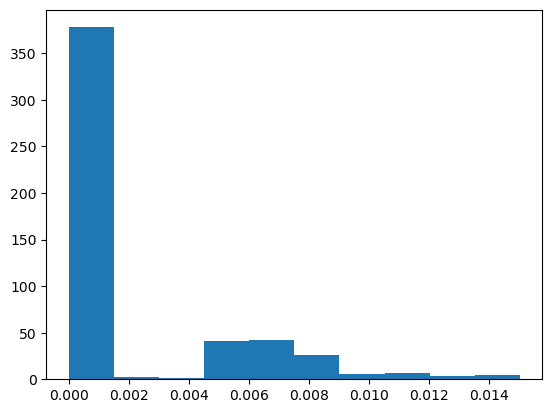

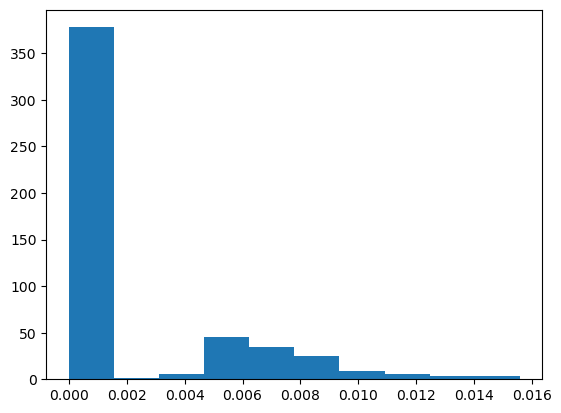

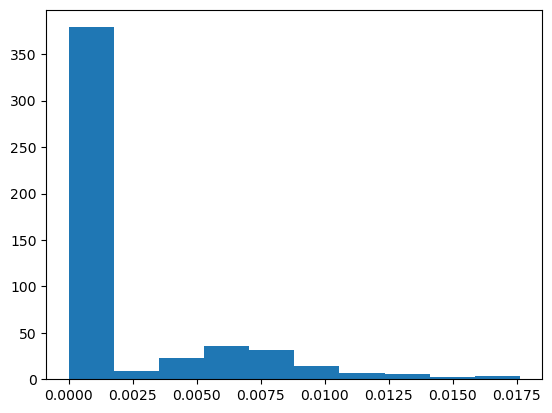

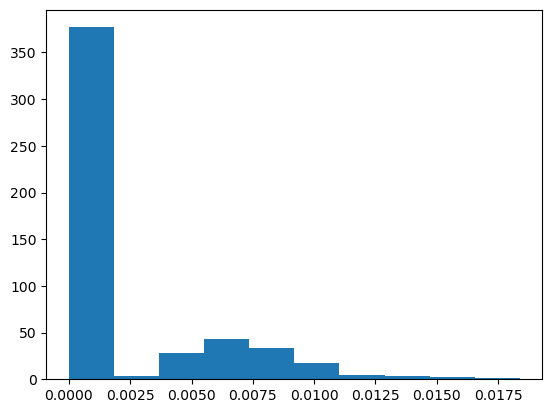

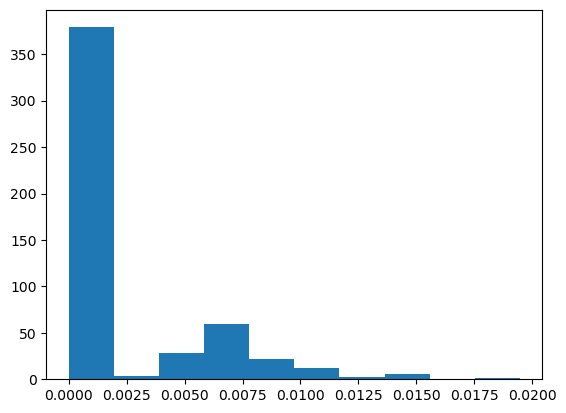

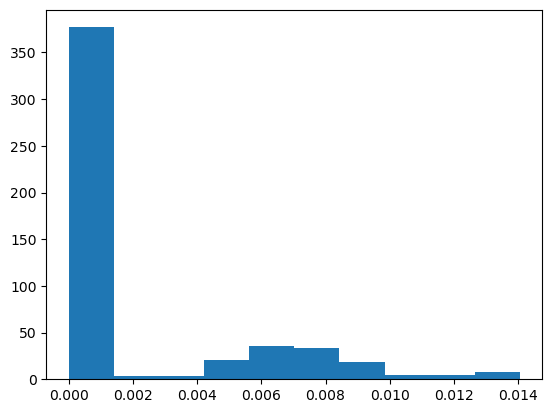

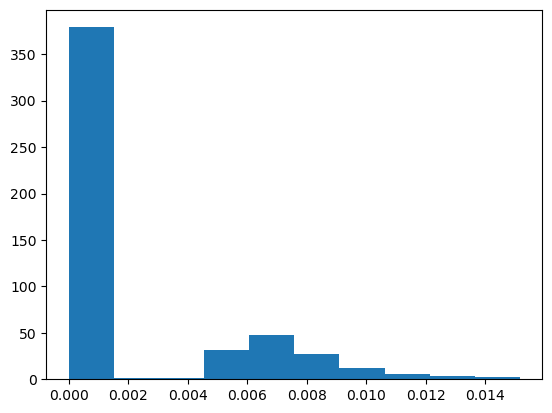

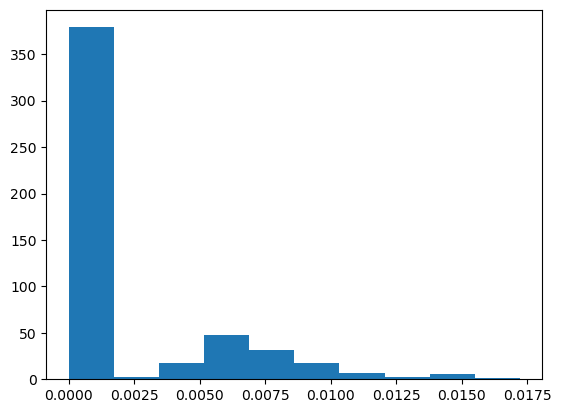

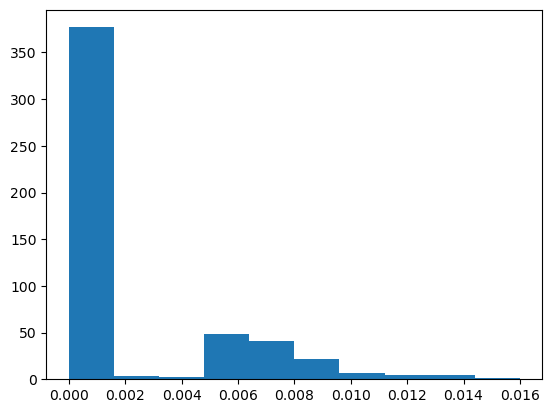

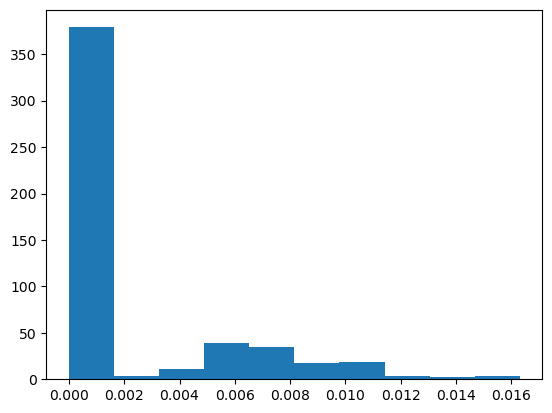

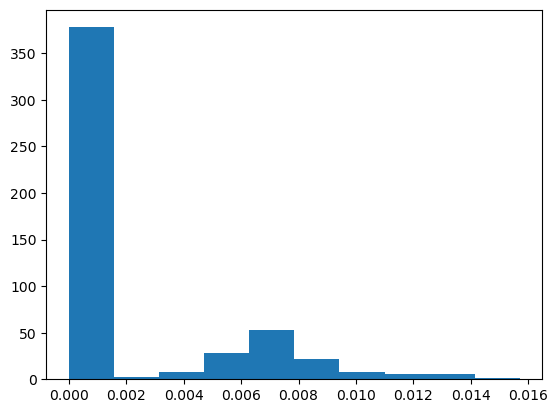

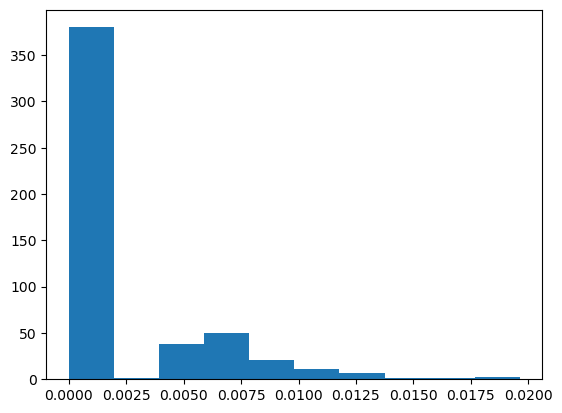

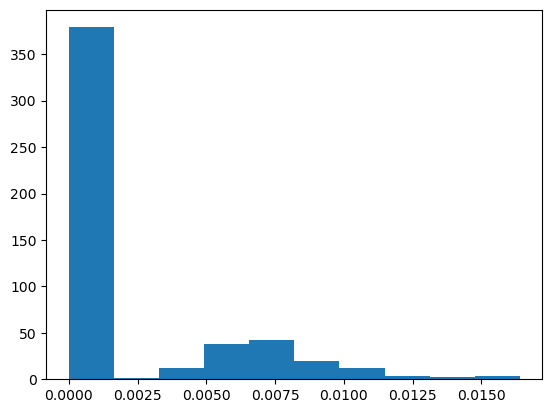

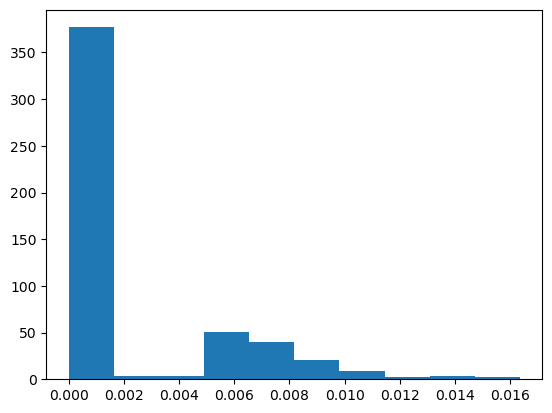

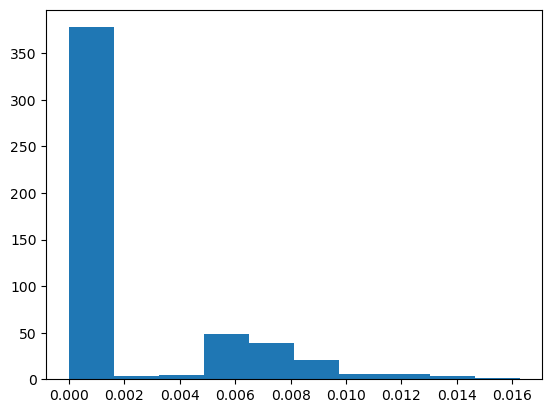

In [42]:
print(z.shape)
print(np.argmax(z, axis=1))

for i in range(len(z)):
    plt.hist(z[i])
    plt.show()